In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

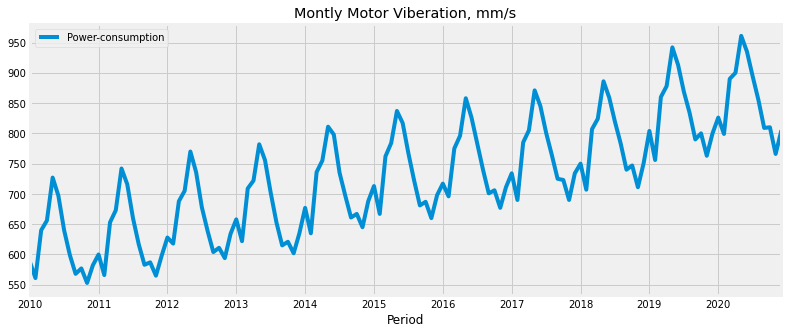

In [71]:
df = pd.read_csv('./motor_power_consumption.csv', sep=',', parse_dates=['Period'], index_col='Period')

df.plot(figsize=(12,5))
plt.title('Montly Motor Viberation, mm/s')
plt.show()


In [72]:
df.head()

,Power-consumption
Period,
2010-01-01,589
2010-02-01,561
2010-03-01,640
2010-04-01,656
2010-05-01,727


In [73]:
df.describe()

,Power-consumption
count,132.000000
mean,727.477273
std,94.008727
min,553.000000
25%,657.500000
50%,722.500000
75%,799.250000
max,961.000000


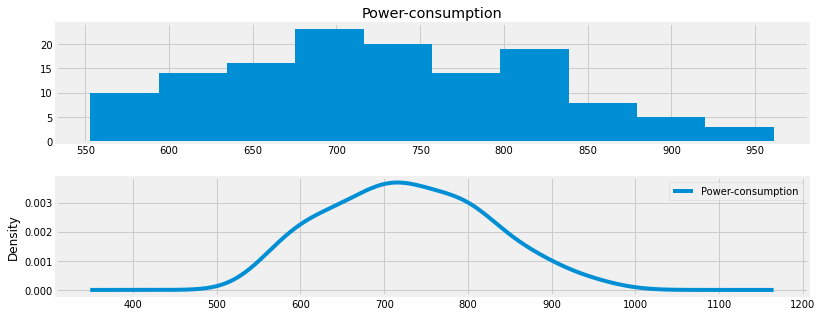

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,5))
df.hist(ax=ax1)
df.plot(kind='kde', ax=ax2)
plt.show();

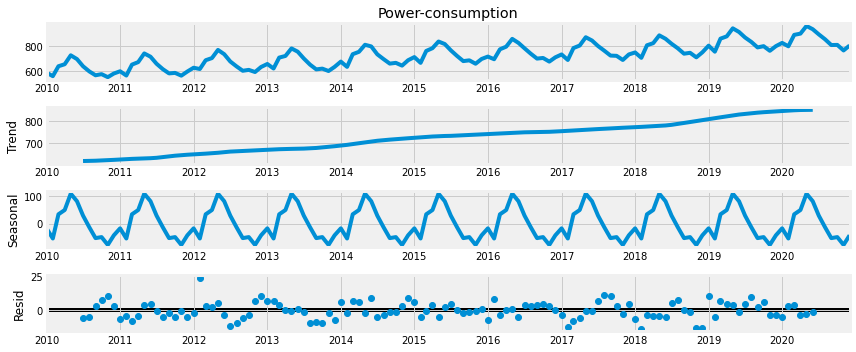

In [75]:
decomposition = seasonal_decompose(df['Power-consumption'], freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 5
decomposition.plot()
plt.show();

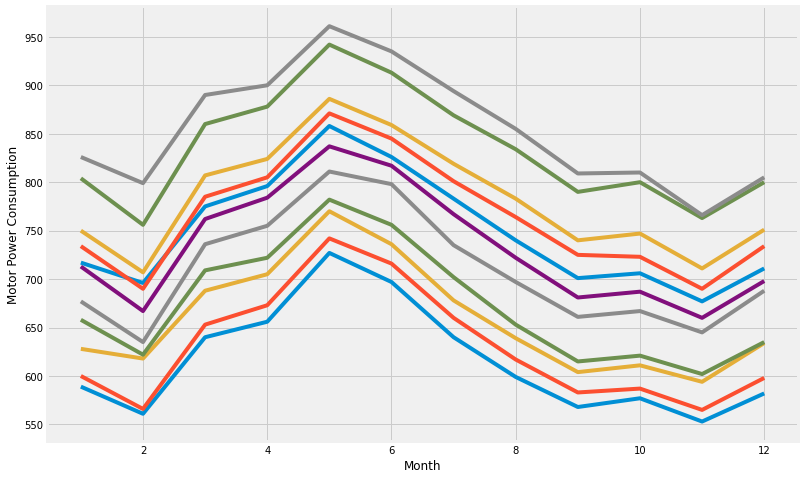

In [76]:
df['year'] = df.index.year
df['month'] = df.index.month
df_pivot = pd.pivot_table(df, values='Power-consumption', index='month', columns='year', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('Month')
plt.ylabel('Motor Power Consumption')
plt.show()

In [77]:
df.drop(['year', 'month'], axis=1, inplace=True)

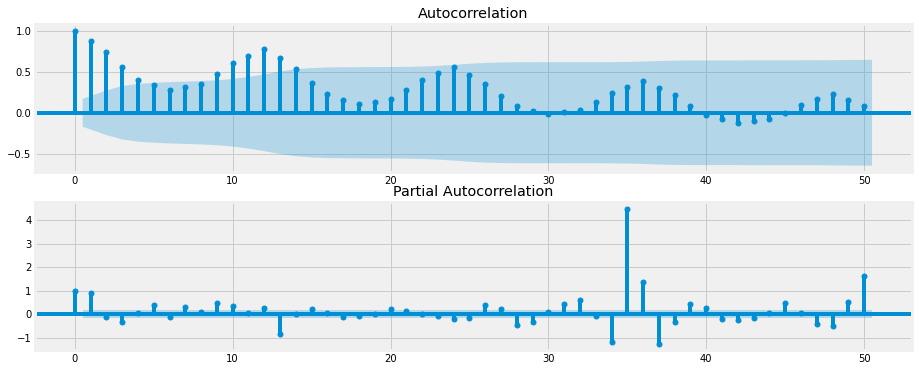

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

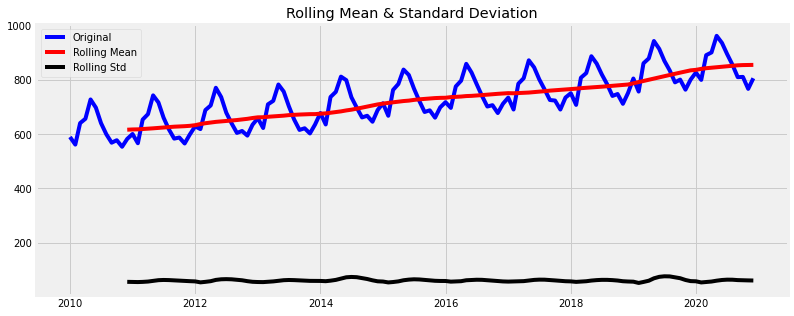

In [79]:
#Determing rolling statistics
rolmean = pd.Series(df['Power-consumption']).rolling(window=12).mean()
rolstd = pd.Series(df['Power-consumption']).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df['Power-consumption'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [80]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Power-consumption'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.544955
p-value                          0.882941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [81]:
df_diff = df.diff().diff(12)

In [82]:
df_diff.dropna(inplace=True)

In [83]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff['Power-consumption'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -4.212011
p-value                          0.000629
#Lags Used                      12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


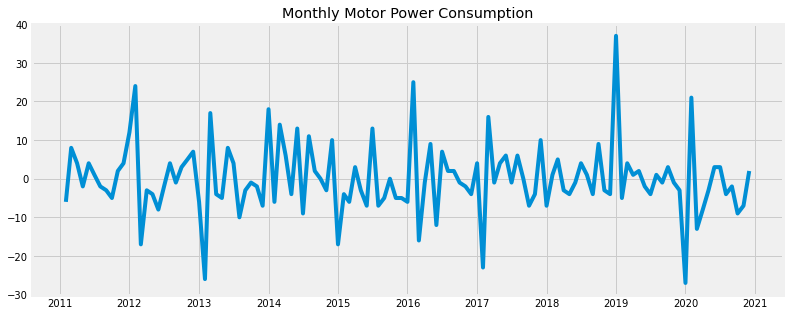

In [84]:
plt.plot(df_diff['Power-consumption'])
plt.title('Monthly Motor Power Consumption')
plt.savefig('diffplot')
plt.show()


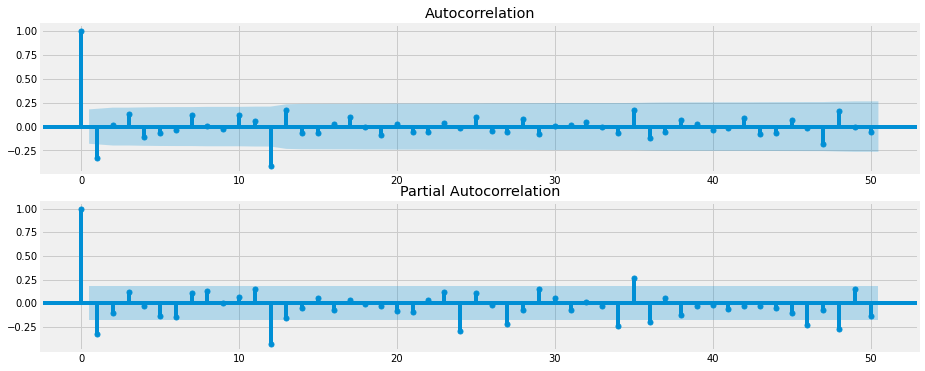

In [86]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

In [87]:

import pmdarima as pm
model = pm.auto_arima(df['Power-consumption'], d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=837.419, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=869.399, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=833.113, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=824.949, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=857.774, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=826.860, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=826.860, Time=0.80 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=833.246, Time=0.34 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=828.288, Time=1.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=835.419, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=826.784, Time=0.45 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=826.706, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=825.571, Time=0.29 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=828.694, Time=0.65 sec
 ARIMA(0,1,1)(0,1,1)[12] intercep

In [88]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -408.474
Date:                            Tue, 19 Jan 2021   AIC                            824.949
Time:                                    19:04:30   BIC                            836.065
Sample:                                         0   HQIC                           829.463
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.248      0.046      0.963      -0.475       0.497
ma.L1         -0.3211      0.100     -3.201      0.001      -0.518      -0.124
ma.S.L12      -0.6099      0.089     -6.841      0.000      -0.785      -0.435
sigma2        53.4893      6.045      8.849      0.000      41.642      65.337
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                47.63
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             1.00
Prob(H) (two-sided):                  0.93   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Period'>

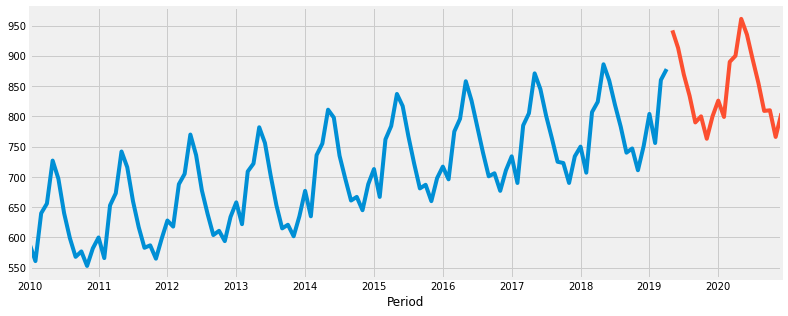

In [89]:
#divide into train and validation set
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

#plotting the data
train['Power-consumption'].plot()
test['Power-consumption'].plot()

In [90]:
model = SARIMAX(train['Power-consumption'],order=(1,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

/home/srijeyanthan/snap/jupyter/common/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/srijeyanthan/snap/jupyter/common/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                    Power-consumption   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -343.821
Date:                              Tue, 19 Jan 2021   AIC                            693.642
Time:                                      19:04:40   BIC                            701.428
Sample:                                  01-01-2010   HQIC                           696.792
                                       - 04-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3250      0.103     -3.150      0.002      -0.527      -0.123
ma.S.L12      -0.5745      0.111     -5.170      0.000      -0.792      -0.357
sigma2        57.8820      6.648      8.707      0.000      44.852      70.912
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                42.33
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.99
Prob(H) (two-sided):                  0.50   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

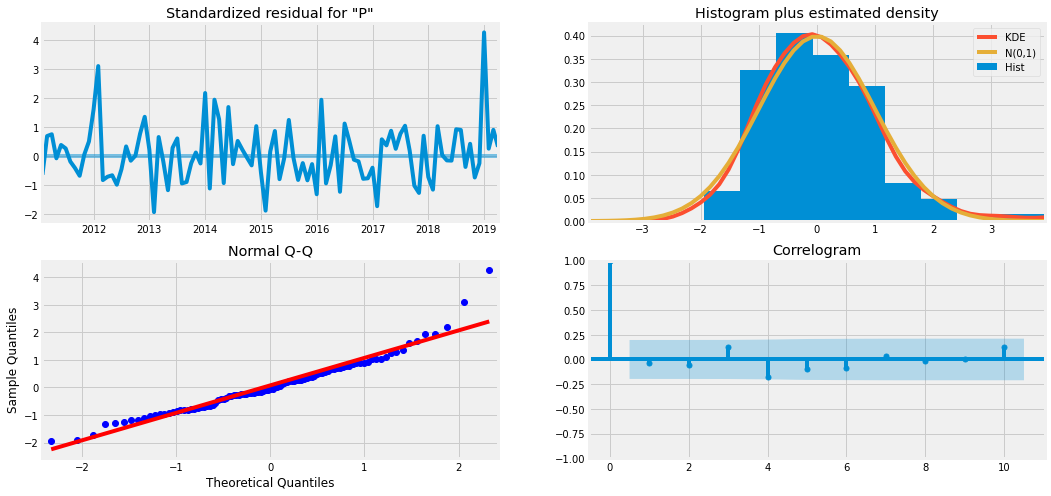

In [91]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

In [92]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

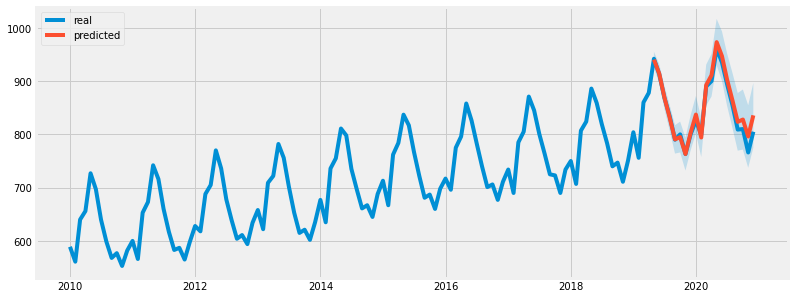

In [93]:

# Plot past CO2 levels
plt.plot(df.index, df, label='real')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [94]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(0,1,1,12) Predictions')

In [95]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Power-consumption'][i]}")

predicted=940.3396138, expected=942
predicted=913.9259304, expected=913
predicted=869.6935562, expected=869
predicted=831.1214606, expected=834
predicted=790.6078883, expected=790
predicted=794.9551499, expected=800
predicted=763.0658484, expected=763
predicted=802.8288549, expected=800
predicted=837.2186652, expected=826
predicted=794.1537728, expected=799
predicted=892.5960102, expected=890
predicted=911.002753 , expected=900
predicted=973.2101825, expected=961
predicted=946.8394567, expected=935
predicted=902.593122 , expected=894
predicted=864.0255633, expected=855
predicted=823.5105167, expected=809
predicted=827.8582573, expected=810
predicted=795.9688002, expected=766
predicted=835.7318573, expected=805


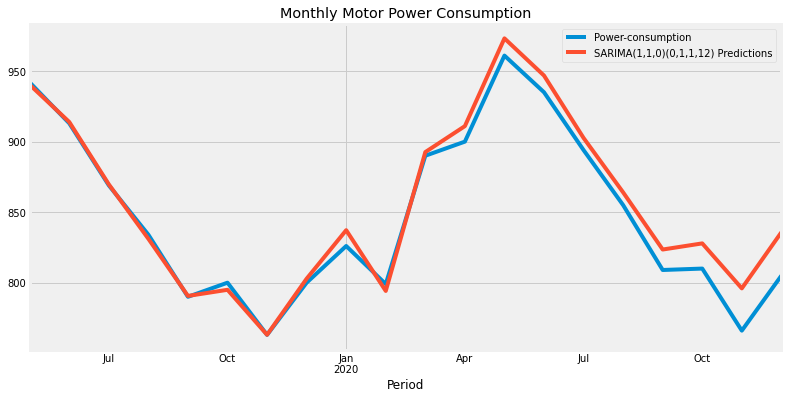

In [96]:
# Plot predictions against known values
title = 'Monthly Motor Power Consumption'
ax = test['Power-consumption'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);


In [97]:
r2_score(test['Power-consumption'], predictions)

0.9553277640498591

In [98]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Power-consumption'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Power-consumption'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Power-consumption'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Power-consumption'])/np.abs(test['Power-consumption']))*100 

evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.955328,8.955363,156.998228,1.076669


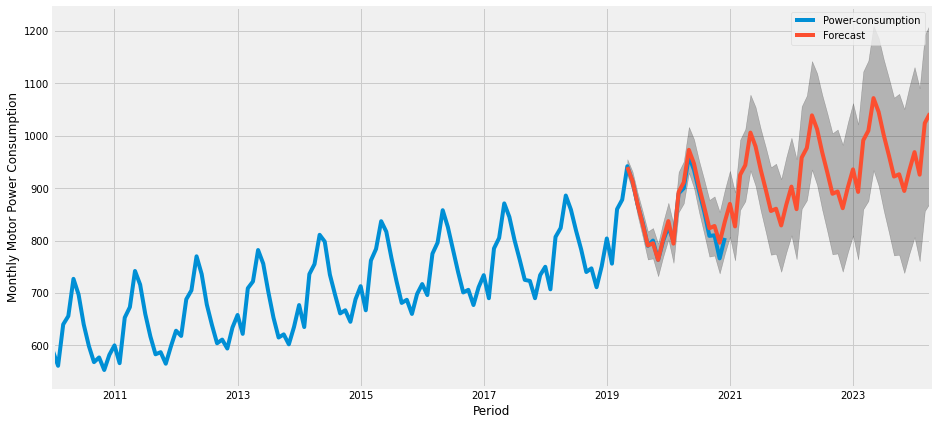

In [100]:
pred_f = results.get_forecast(steps=60)
pred_ci = pred_f.conf_int()
ax = df.plot(label='Power-consumption', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Period')
ax.set_ylabel('Monthly Motor Power Consumption')
plt.legend()
plt.show()